In [1]:
from dataclasses import dataclass
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

import statsmodels.api as sm

from utils import plot_residuals_diagnostics, validate_on_dev_set, fit_ols_model, backward_stepwise_selection, fit_lasso_model

# Load data from EDA
train_df = pd.read_csv('./train_df.csv')
dev_df = pd.read_csv('./dev_df.csv')

print(f"Train set: {train_df.shape}")
print(f"Dev set:   {dev_df.shape}")
print(f"\nTrain columns: {train_df.columns.tolist()}")

Train set: (1807, 45)
Dev set:   (452, 45)

Train columns: ['PRSM', 'FICO', 'TotalAmtOwed', 'Volume', 'Stress', 'Num_Delinquent', 'Num_CreditLines', 'WomanOwned', 'CorpStructure', 'NAICS', 'Months', 'Prop_Delinquent_Credit', 'FICO_category', 'NAICS_2digit', 'NAICS_industry', 'log_Volume', 'log_Months', 'log_TotalAmtOwed', 'CorpStructure_Corp', 'CorpStructure_LLC', 'CorpStructure_Partner', 'CorpStructure_Sole', 'NAICS_ind_Accommodation and Food Services', 'NAICS_ind_Retail Trade', 'NAICS_code_441120', 'NAICS_code_444140', 'NAICS_code_444240', 'NAICS_code_445110', 'NAICS_code_445131', 'NAICS_code_445230', 'NAICS_code_445240', 'NAICS_code_445250', 'NAICS_code_445291', 'NAICS_code_445292', 'NAICS_code_445320', 'NAICS_code_458210', 'NAICS_code_458310', 'NAICS_code_459210', 'NAICS_code_459310', 'NAICS_code_459910', 'NAICS_code_722330', 'NAICS_code_722410', 'NAICS_code_722511', 'NAICS_code_722513', 'NAICS_code_722514']


## Model 0: Baseline OLS

**Formula**: 
```
PRSM ~ FICO_category + TotalAmtOwed + Volume + Stress + Num_Delinquent + Num_CreditLines + WomanOwned + Months + CorpStructure_Corp + CorpStructure_LLC + CorpStructure_Partner + NAICS_Retail Trade
```

**Rationale**: Establishes baseline. All predictors included, simple linear relationships.


=== Model 0: Baseline OLS Metrics ===
R2 = 0.7434
Adj R2 = 0.7415


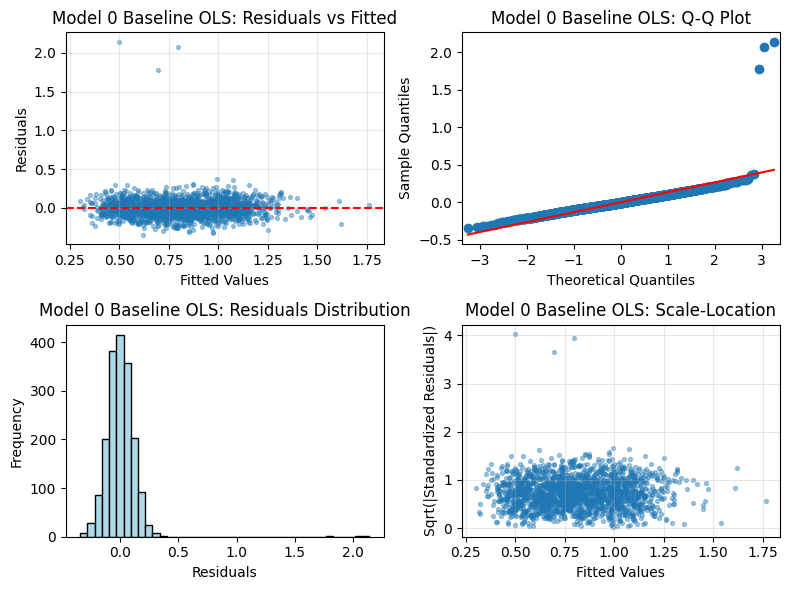

In [2]:
# Model 0: Baseline OLS
base_predictors = ['FICO_category', 'TotalAmtOwed', 'Volume', 'Stress', 'Num_Delinquent', 'Num_CreditLines', 'Prop_Delinquent_Credit','WomanOwned', 'Months', 'CorpStructure_Corp', 'CorpStructure_LLC', 'CorpStructure_Partner', 'NAICS_ind_Retail Trade']

X_train_base = train_df[base_predictors].copy().astype(float)
X_train_base_with_const = sm.add_constant(X_train_base)
X_dev_base = dev_df[base_predictors].copy().astype(float)
X_dev_base_with_const = sm.add_constant(X_dev_base)
y_train = train_df['PRSM'].astype(float)
y_dev = dev_df['PRSM'].astype(float)

# Train model using utility function
model_baselineOLS, metrics_baselineOLS = fit_ols_model(X_train_base_with_const, y_train, 'Model 0: Baseline OLS')

# Store metrics for comparison
baselineOLS_r2 = metrics_baselineOLS['r2']
baselineOLS_adj_r2 = metrics_baselineOLS['adj_r2']

# Model 0: Residual diagnostics
residuals_baselineOLS = model_baselineOLS.resid
fitted_baselineOLS = model_baselineOLS.fittedvalues
plot_residuals_diagnostics(residuals_baselineOLS, fitted_baselineOLS, 'Model 0 Baseline OLS', color='lightblue')

Outlier Samples (|residuals| > 0.5):
Number of outliers: 3
Outlier indices: [49, 866, 1152]

Outlier Sample Details:
   Index  Actual_PRSM  Predicted_PRSM  Residual  Abs_Residual
0     49     2.640174        0.499693  2.140481      2.140481
1    866     2.867347        0.795454  2.071893      2.071893
2   1152     2.467309        0.693537  1.773772      1.773772

Original training set size: 1807
Removed 3 outlier samples
New training set size: 1804


=== Model 0: OLS Metrics ===
R2 = 0.8267
Adj R2 = 0.8254


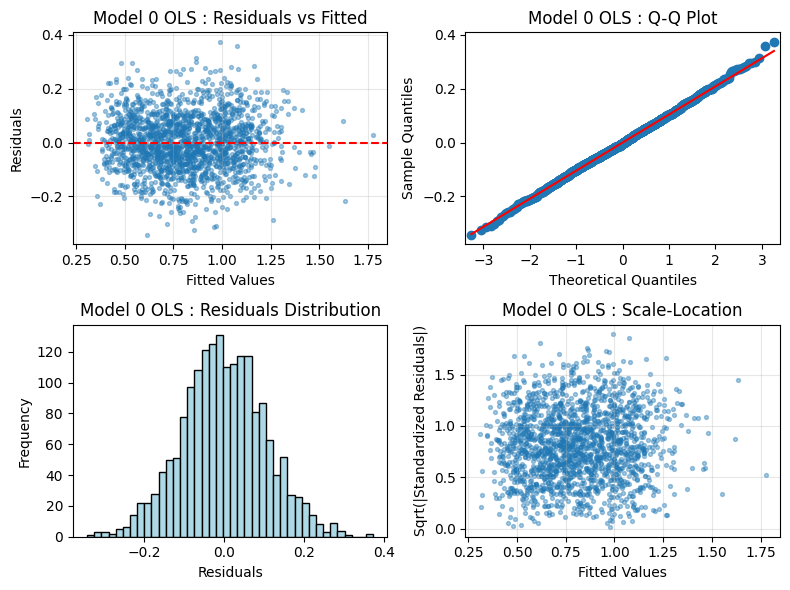


=== Model 0 OLS  Dev Set Performance ===
RMSE = 0.2168
MAE = 0.1029
95% Prediction Interval Coverage = 0.9469 (94.69%)
PI method = OLS obs_ci


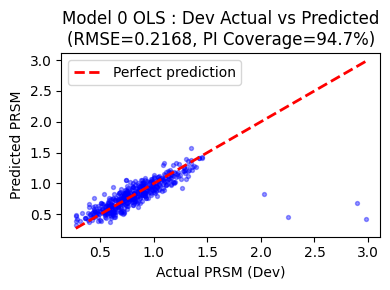

In [3]:
# Model 0: Identify outlier samples (residuals > 0.5)
outlier_threshold = 0.5
abs_residuals = np.abs(residuals_baselineOLS)
outlier_mask = abs_residuals > outlier_threshold
outlier_indices = np.where(outlier_mask)[0]

print(f"Outlier Samples (|residuals| > {outlier_threshold}):")
print(f"Number of outliers: {len(outlier_indices)}")
print(f"Outlier indices: {outlier_indices.tolist()}\n")

# Display details of outlier samples
if len(outlier_indices) > 0:
    outlier_data = pd.DataFrame({
        'Index': outlier_indices,
        'Actual_PRSM': y_train.iloc[outlier_indices].values,
        'Predicted_PRSM': fitted_baselineOLS.iloc[outlier_indices].values,
        'Residual': residuals_baselineOLS.iloc[outlier_indices].values,
        'Abs_Residual': abs_residuals.iloc[outlier_indices].values
    })
    print("Outlier Sample Details:")
    print(outlier_data.to_string())
    print()
    
else:
    print("No outliers found!")


# Model 0.5: OLS with Outliers Removed
# Create training data without outliers
inlier_mask = (~outlier_mask).values  # Convert Series to numpy boolean array
X_train_base_del = X_train_base[inlier_mask].copy().astype(float)
X_train_base_with_const_del = sm.add_constant(X_train_base_del)
y_train_base_del = y_train[inlier_mask].copy().astype(float)

print(f"Original training set size: {len(X_train_base)}")
print(f"Removed {len(outlier_indices)} outlier samples")
print(f"New training set size: {len(X_train_base_del)}\n")

# Train OLS model without outliers
model_baselineOLS_del, metrics_baselineOLS_del = fit_ols_model(X_train_base_with_const_del, y_train_base_del, 'Model 0: OLS')

# Store metrics for comparison
baselineOLS_del_r2 = metrics_baselineOLS_del['r2']
baselineOLS_del_adj_r2 = metrics_baselineOLS_del['adj_r2']

# Model 0.5: Residual diagnostics
residuals_baselineOLS_del = model_baselineOLS_del.resid
fitted_baselineOLS_del = model_baselineOLS_del.fittedvalues
plot_residuals_diagnostics(residuals_baselineOLS_del, fitted_baselineOLS_del, 'Model 0 OLS ', color='lightblue')

# Model 0.5: Dev set validation
rmse_baselineOLS_del, mae_baselineOLS_del, coverage_baselineOLS_del = validate_on_dev_set(
    model_baselineOLS_del, X_dev_base_with_const, y_dev, 'Model 0 OLS ', 'blue', model_type='OLS')


## Model 1: LASSO Regression for baseline OLS

**Rationale**: Penalized regression that automatically performs variable selection and shrinkage.
- LASSO adds L1 penalty: minimizes $\sum (y_i - \hat{y}_i)^2 + \alpha \sum |\beta_j|$
- Forces some coefficients exactly to zero → automatic feature selection
- Uses cross-validation to select optimal $\alpha$ (regularization strength)
- **Benefits**: Handles multicollinearity; produces sparse models; prevents overfitting

**Method**: LassoCV with 5-fold cross-validation to select best $\alpha$

Running LassoCV to find optimal alpha (shuffled CV)...
Optimal alpha selected: 0.000751

=== Model 1: LASSO (Baseline) Metrics ===
R2 = 0.8263
Adj R2 = 0.8252
Non-zero coefficients: 11 out of 13

=== Model 1: LASSO (Baseline) Selected Features ===
                   Feature  Coefficient  Abs_Coef
7               WomanOwned     0.138852  0.138852
10       CorpStructure_LLC     0.103590  0.103590
1             TotalAmtOwed     0.100152  0.100152
11   CorpStructure_Partner     0.071940  0.071940
0            FICO_category     0.053711  0.053711
3                   Stress     0.050118  0.050118
8                   Months     0.012652  0.012652
9       CorpStructure_Corp     0.011784  0.011784
2                   Volume    -0.002262  0.002262
12  NAICS_ind_Retail Trade    -0.001764  0.001764
6   Prop_Delinquent_Credit    -0.001051  0.001051

Removed features (zero coefficient): ['Num_Delinquent', 'Num_CreditLines']


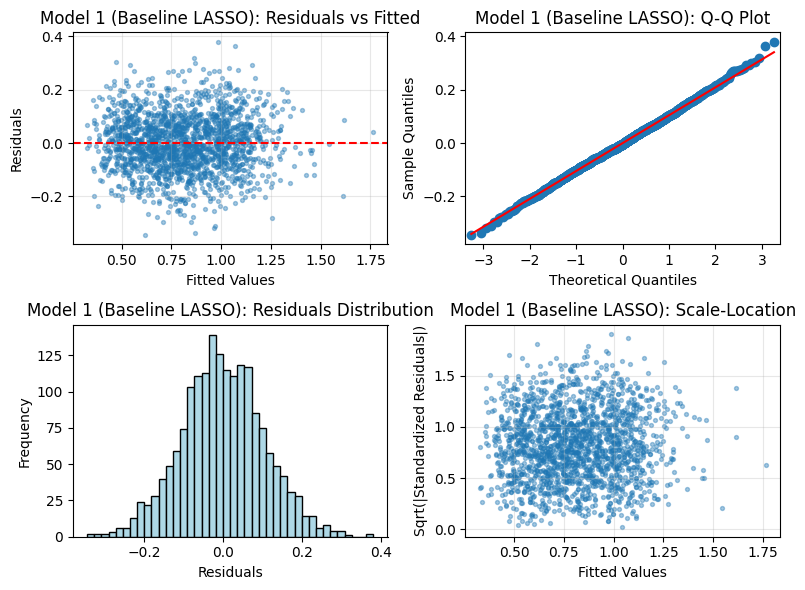


=== Model 1: baseline LASSO Dev Set Performance ===
RMSE = 0.2166
MAE = 0.1029
95% Prediction Interval Coverage = 0.9513 (95.13%)
PI method = Residual quantile


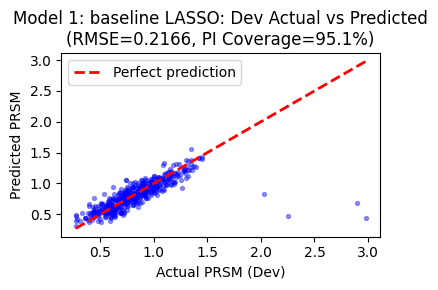

In [4]:
# Model 1: LASSO Regression with Cross-Validation
# Fit LASSO using utility function
model_baselineLASSO, scaler_baselineLASSO, metrics_baselineLASSO = fit_lasso_model(
    X_train_base_del, y_train_base_del, base_predictors, 'Model 1: LASSO (Baseline)'
)

# Store metrics
baselineLASSO_r2 = metrics_baselineLASSO['r2']
baselineLASSO_adj_r2 = metrics_baselineLASSO['adj_r2']
lasso_coefs_baselineLASSO = metrics_baselineLASSO['coefficients']

# Prepare data for residual diagnostics
X_train_lasso_scaled = scaler_baselineLASSO.transform(X_train_base_del)
y_pred_train_baselineLASSO = model_baselineLASSO.predict(X_train_lasso_scaled)

# Model 1: Residual diagnostics
residuals_baselineLASSO = y_train_base_del - y_pred_train_baselineLASSO
fitted_baselineLASSO = y_pred_train_baselineLASSO
plot_residuals_diagnostics(residuals_baselineLASSO, fitted_baselineLASSO, 'Model 1 (Baseline LASSO)', color='lightblue')

# Model 1: Dev set validation
X_dev_lasso_scaled = scaler_baselineLASSO.transform(X_dev_base)
rmse_baselineLASSO, mae_baselineLASSO, coverage_baselineLASSO = validate_on_dev_set(
    model_baselineLASSO, X_dev_lasso_scaled, y_dev, 'Model 1: baseline LASSO', 'blue', 
    model_type='LASSO', train_residuals=metrics_baselineLASSO['train_residuals'])

## Model 2: Backward Stepwise OLS for baseline OLS

**Rationale**: Automatically select the most important predictors by iteratively removing features with high p-values.
- Starts with all predictors from Model 0
- Removes features with p-value > 0.05 one at a time (highest p-value first)
- Stops when all remaining features are significant or when AIC stops improving
- **Benefits**: Improved interpretability by removing weak predictors; reduces overfitting

**Method**: Backward stepwise selection based on p-values and AIC

Starting backward stepwise selection (criterion: CV RMSE)...
Initial predictors (13): ['FICO_category', 'TotalAmtOwed', 'Volume', 'Stress', 'Num_Delinquent', 'Num_CreditLines', 'Prop_Delinquent_Credit', 'WomanOwned', 'Months', 'CorpStructure_Corp', 'CorpStructure_LLC', 'CorpStructure_Partner', 'NAICS_ind_Retail Trade']
Initial CV RMSE: 0.105215


No further meaningful CV RMSE improvement. Stopping.
Final predictors (13): ['FICO_category', 'TotalAmtOwed', 'Volume', 'Stress', 'Num_Delinquent', 'Num_CreditLines', 'Prop_Delinquent_Credit', 'WomanOwned', 'Months', 'CorpStructure_Corp', 'CorpStructure_LLC', 'CorpStructure_Partner', 'NAICS_ind_Retail Trade']

                            OLS Regression Results                            
Dep. Variable:                   PRSM   R-squared:                       0.827
Model:                            OLS   Adj. R-squared:                  0.825
Method:                 Least Squares   F-statistic:                     656.7
Date:                Th

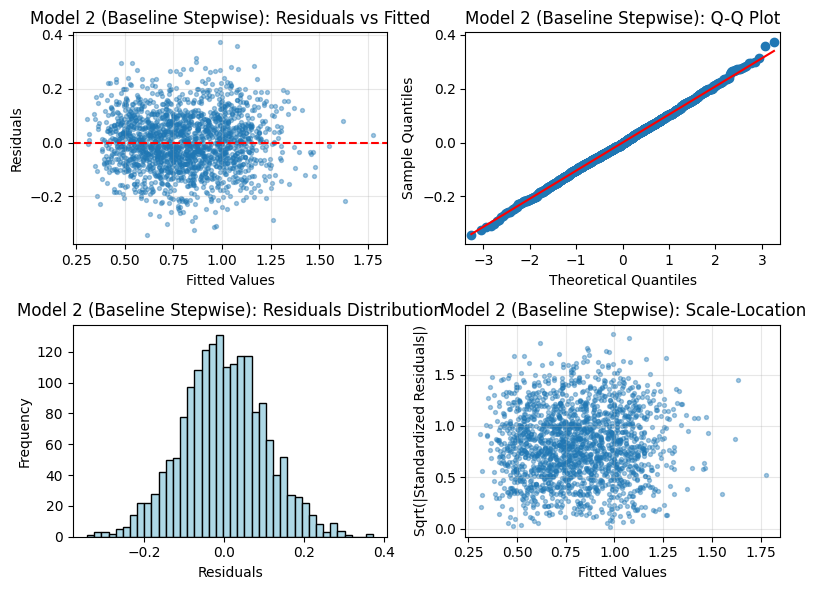


=== Model 2: Baseline Stepwise OLS Dev Set Performance ===
RMSE = 0.2168
MAE = 0.1029
95% Prediction Interval Coverage = 0.9469 (94.69%)
PI method = OLS obs_ci


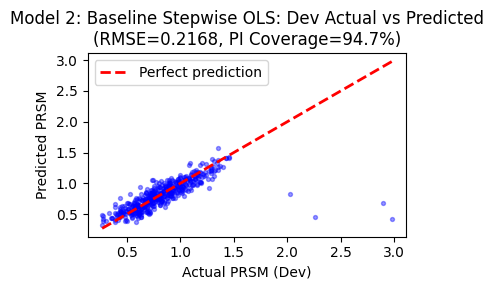

In [5]:
# Model 2: Backward Stepwise OLS (Baseline Predictors)

# Perform backward stepwise selection using utility function
stepwise_predictors_baselineStep, model_baselineStep = backward_stepwise_selection(X_train_base_with_const_del, y_train_base_del, threshold_p=0.05)

# Print model summary
print("=" * 80)
print(model_baselineStep.summary())

# Store metrics
baselineStep_r2 = model_baselineStep.rsquared
baselineStep_adj_r2 = model_baselineStep.rsquared_adj
print(f"\n=== Model 2 (Baseline Stepwise) Metrics ===")
print(f"R² = {baselineStep_r2:.4f}")
print(f"Adj R² = {baselineStep_adj_r2:.4f}")

# Model 2: Residual diagnostics
residuals_baselineStep = model_baselineStep.resid
fitted_baselineStep = model_baselineStep.fittedvalues
plot_residuals_diagnostics(residuals_baselineStep, fitted_baselineStep, 'Model 2 (Baseline Stepwise)', color='lightblue')

# Model 2: Dev set validation
X_dev_baselineStep = dev_df[stepwise_predictors_baselineStep].copy().astype(float)
X_dev_baselineStep = sm.add_constant(X_dev_baselineStep)

rmse_baselineStep, mae_baselineStep, coverage_baselineStep = validate_on_dev_set(
    model_baselineStep, X_dev_baselineStep, y_dev, 'Model 2: Baseline Stepwise OLS', 'blue', model_type='OLS')


## Model 3: OLS with preprocessed predictors

**Formula**: 
```
PRSM ~ FICO_category + log_TotalAmtOwed + log_Volume + Stress + log_Months + 
        Num_CreditLines + Prop_Delinquent_Credit  + WomanOwned + 
       CorpStructure_Corp + CorpStructure_LLC + CorpStructure_Partner + NAICS_Retail Trade
```

**Rationale**: Preprocessed predictors included, simple linear relationships.


=== Model 3: Prep OLS Metrics ===
R2 = 0.7004
Adj R2 = 0.6984
                            OLS Regression Results                            
Dep. Variable:                   PRSM   R-squared:                       0.700
Model:                            OLS   Adj. R-squared:                  0.698
Method:                 Least Squares   F-statistic:                     349.6
Date:                Thu, 12 Feb 2026   Prob (F-statistic):               0.00
Time:                        15:08:53   Log-Likelihood:                 947.47
No. Observations:                1807   AIC:                            -1869.
Df Residuals:                    1794   BIC:                            -1797.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------

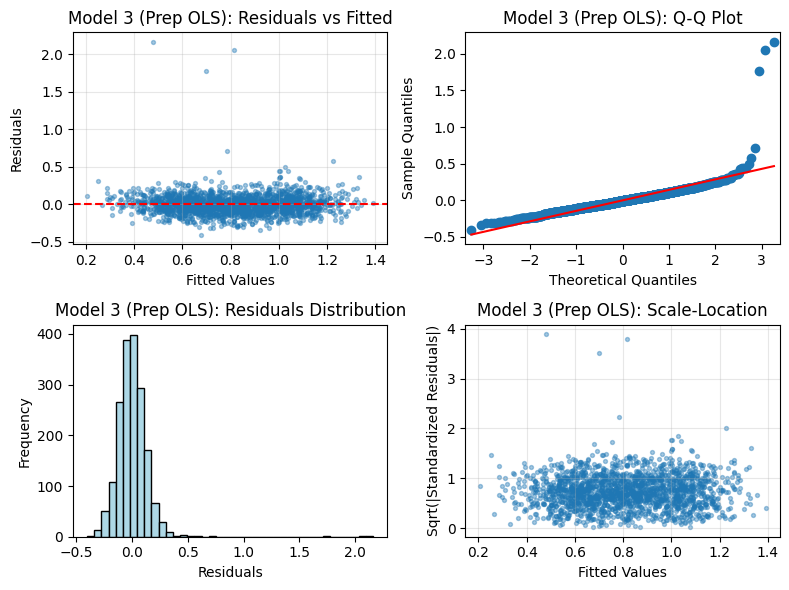

In [6]:
# Model 3: OLS with Preprocessed Variables
preprocessed_predictors = ['FICO_category', 'log_TotalAmtOwed', 'log_Volume', 'Stress', 'log_Months',
                   'Num_CreditLines', 'Prop_Delinquent_Credit', 'WomanOwned',
                   'CorpStructure_Corp', 'CorpStructure_LLC', 'CorpStructure_Partner',
                   'NAICS_ind_Retail Trade']

X_train_preprocessed = train_df[preprocessed_predictors].copy().astype(float)
X_train_preprocessed_with_const = sm.add_constant(X_train_preprocessed)
X_dev_preprocessed = dev_df[preprocessed_predictors].copy().astype(float)
X_dev_preprocessed_with_const = sm.add_constant(X_dev_preprocessed)

# Train model using utility function
model_preOLS, metrics_preOLS = fit_ols_model(X_train_preprocessed_with_const, y_train, 'Model 3: Prep OLS')
print(model_preOLS.summary())

# Store metrics
preOLS_r2 = metrics_preOLS['r2']
preOLS_adj_r2 = metrics_preOLS['adj_r2']

# Model 3: Residual diagnostics
residuals_preOLS = model_preOLS.resid
fitted_preOLS = model_preOLS.fittedvalues
plot_residuals_diagnostics(residuals_preOLS, fitted_preOLS, 'Model 3 (Prep OLS)', color='lightblue')

Outlier Samples (|residuals| > 0.5):
Number of outliers: 5
Outlier indices: [49, 134, 866, 952, 1152]

Outlier Sample Details:
   Index  Actual_PRSM  Predicted_PRSM  Residual  Abs_Residual
0     49     2.640174        0.479060  2.161114      2.161114
1    134     1.805559        1.225207  0.580352      0.580352
2    866     2.867347        0.815887  2.051460      2.051460
3    952     1.495186        0.784426  0.710760      0.710760
4   1152     2.467309        0.699310  1.767999      1.767999

Original training set size: 1807
Removed 5 outlier samples
New training set size: 1802


=== Model 3 Preprocessed OLS Metrics ===
R2 = 0.7843
Adj R2 = 0.7829


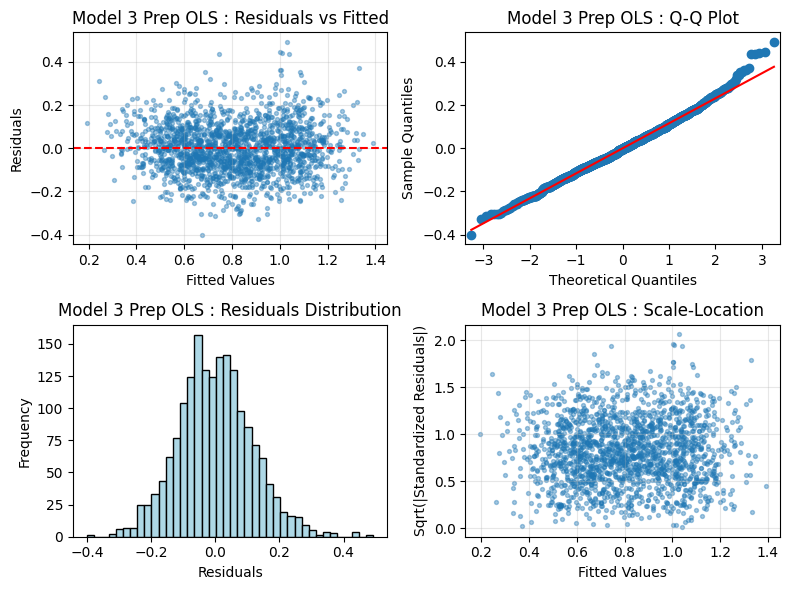


=== Model 3 Prep OLS  Dev Set Performance ===
RMSE = 0.2224
MAE = 0.1115
95% Prediction Interval Coverage = 0.9381 (93.81%)
PI method = OLS obs_ci


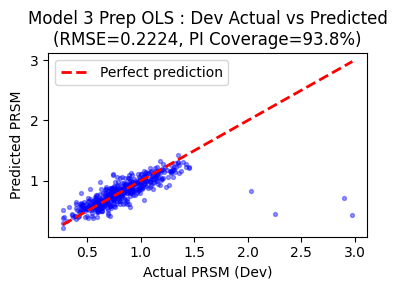

In [7]:
# Model 3: Identify outlier samples (residuals > 0.5)
outlier_pre_threshold = 0.5
abs_residuals = np.abs(residuals_preOLS)
outlier_mask = abs_residuals > outlier_pre_threshold
outlier_indices = np.where(outlier_mask)[0]

print(f"Outlier Samples (|residuals| > {outlier_pre_threshold}):")
print(f"Number of outliers: {len(outlier_indices)}")
print(f"Outlier indices: {outlier_indices.tolist()}\n")

# Display details of outlier samples
if len(outlier_indices) > 0:
    outlier_data = pd.DataFrame({
        'Index': outlier_indices,
        'Actual_PRSM': y_train.iloc[outlier_indices].values,
        'Predicted_PRSM': fitted_preOLS.iloc[outlier_indices].values,
        'Residual': residuals_preOLS.iloc[outlier_indices].values,
        'Abs_Residual': abs_residuals.iloc[outlier_indices].values
    })
    print("Outlier Sample Details:")
    print(outlier_data.to_string())
    print()
    
else:
    print("No outliers found!")


# Model 3.5: OLS with Outliers Removed
# Create training data without outliers
inlier_mask = (~outlier_mask).values  # Convert Series to numpy boolean array
X_train_preprocessed_del = X_train_preprocessed[inlier_mask].copy().astype(float)
X_train_preprocessed_with_const_del = sm.add_constant(X_train_preprocessed_del)
y_train_preprocessed_del = y_train[inlier_mask].copy().astype(float)

print(f"Original training set size: {len(X_train_preprocessed)}")
print(f"Removed {len(outlier_indices)} outlier samples")
print(f"New training set size: {len(X_train_preprocessed_del)}\n")

# Train OLS model without outliers
model_preOLS_del, metrics_preOLS_del = fit_ols_model(X_train_preprocessed_with_const_del, y_train_preprocessed_del, 'Model 3 Preprocessed OLS')

# Store metrics for comparison
preOLS_del_r2 = metrics_preOLS_del['r2']
preOLS_del_adj_r2 = metrics_preOLS_del['adj_r2']

# Model 3.5: Residual diagnostics
residuals_preOLS_del = model_preOLS_del.resid
fitted_preOLS_del = model_preOLS_del.fittedvalues
plot_residuals_diagnostics(residuals_preOLS_del, fitted_preOLS_del, 'Model 3 Prep OLS ', color='lightblue')

# Model 3.5: Dev set validation
rmse_preOLS_del, mae_preOLS_del, coverage_preOLS_del = validate_on_dev_set(
    model_preOLS_del, X_dev_preprocessed_with_const, y_dev, 'Model 3 Prep OLS ', 'blue', model_type='OLS')


## Model 4: Backward Stepwise OLS for preprocessed OLS

Starting backward stepwise selection (criterion: CV RMSE)...
Initial predictors (12): ['FICO_category', 'log_TotalAmtOwed', 'log_Volume', 'Stress', 'log_Months', 'Num_CreditLines', 'Prop_Delinquent_Credit', 'WomanOwned', 'CorpStructure_Corp', 'CorpStructure_LLC', 'CorpStructure_Partner', 'NAICS_ind_Retail Trade']
Initial CV RMSE: 0.116742


No further meaningful CV RMSE improvement. Stopping.
Final predictors (12): ['FICO_category', 'log_TotalAmtOwed', 'log_Volume', 'Stress', 'log_Months', 'Num_CreditLines', 'Prop_Delinquent_Credit', 'WomanOwned', 'CorpStructure_Corp', 'CorpStructure_LLC', 'CorpStructure_Partner', 'NAICS_ind_Retail Trade']

                            OLS Regression Results                            
Dep. Variable:                   PRSM   R-squared:                       0.784
Model:                            OLS   Adj. R-squared:                  0.783
Method:                 Least Squares   F-statistic:                     542.2
Date:                Thu, 12 Feb 20

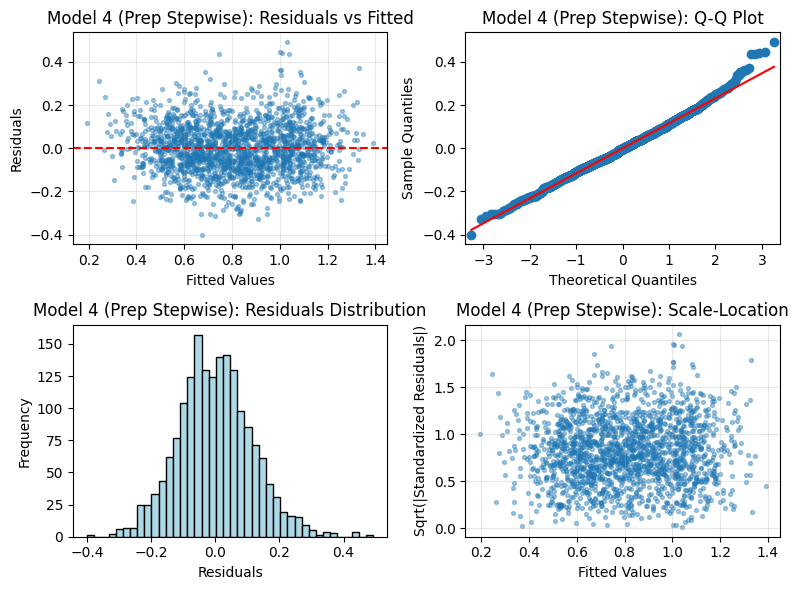


=== Model 4: Prep Stepwise OLS Dev Set Performance ===
RMSE = 0.2224
MAE = 0.1115
95% Prediction Interval Coverage = 0.9381 (93.81%)
PI method = OLS obs_ci


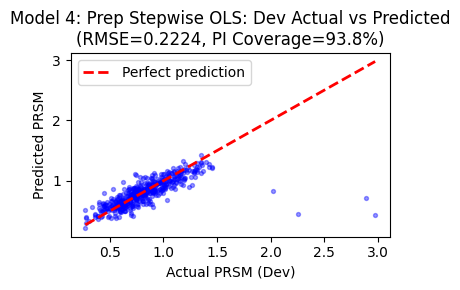

In [8]:
# Model 4: Backward Stepwise OLS (Preprocessed Predictors)

# Perform backward stepwise selection using utility function
stepwise_predictors_preStep, model_preStep = backward_stepwise_selection(X_train_preprocessed_with_const_del, y_train_preprocessed_del, threshold_p=0.05)

# Print model summary
print("=" * 80)
print(model_preStep.summary())

# Store metrics
preStep_r2 = model_preStep.rsquared
preStep_adj_r2 = model_preStep.rsquared_adj
print(f"\n=== Model 4 (Prep Stepwise) Metrics ===")
print(f"R² = {preStep_r2:.4f}")
print(f"Adj R² = {preStep_adj_r2:.4f}")

# Model 4: Residual diagnostics
residuals_preStep = model_preStep.resid
fitted_preStep = model_preStep.fittedvalues
plot_residuals_diagnostics(residuals_preStep, fitted_preStep, 'Model 4 (Prep Stepwise)', color='lightblue')

# Model 4: Dev set validation
X_dev_preStep = dev_df[stepwise_predictors_preStep].copy().astype(float)
X_dev_preStep = sm.add_constant(X_dev_preStep)

rmse_preStep, mae_preStep, coverage_preStep = validate_on_dev_set(
    model_preStep, X_dev_preStep, y_dev, 'Model 4: Prep Stepwise OLS', 'blue', model_type='OLS')


## Model 5: LASSO Regression for preprocessed OLS

Running LassoCV to find optimal alpha (shuffled CV)...
Optimal alpha selected: 0.000186

=== Model 5: LASSO (Preprocessed) Metrics ===
R2 = 0.7843
Adj R2 = 0.7829
Non-zero coefficients: 12 out of 12

=== Model 5: LASSO (Preprocessed) Selected Features ===
                   Feature  Coefficient  Abs_Coef
7               WomanOwned     0.138645  0.138645
9        CorpStructure_LLC     0.104768  0.104768
1         log_TotalAmtOwed     0.094711  0.094711
10   CorpStructure_Partner     0.071483  0.071483
0            FICO_category     0.055241  0.055241
3                   Stress     0.043694  0.043694
4               log_Months     0.019902  0.019902
2               log_Volume    -0.016561  0.016561
8       CorpStructure_Corp     0.014188  0.014188
11  NAICS_ind_Retail Trade    -0.001580  0.001580
6   Prop_Delinquent_Credit    -0.001303  0.001303
5          Num_CreditLines    -0.000316  0.000316


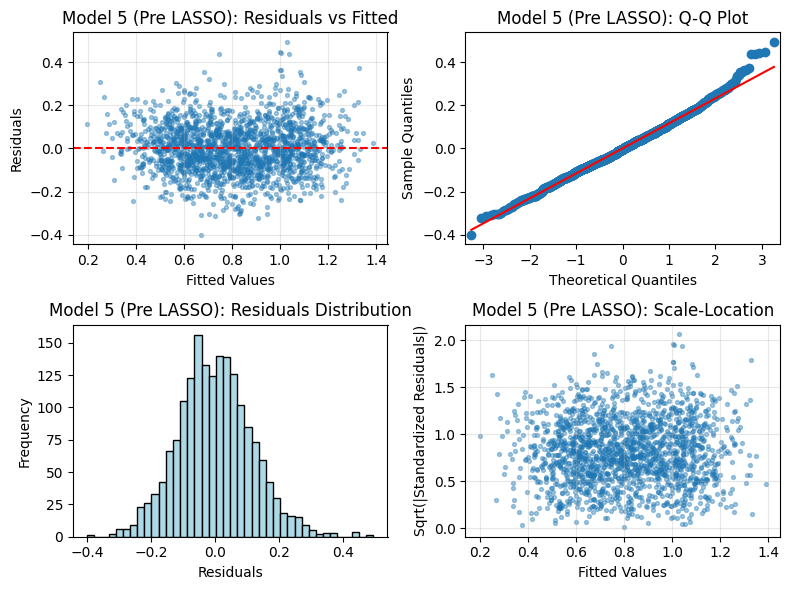


=== Model 5: Prep LASSO Dev Set Performance ===
RMSE = 0.2224
MAE = 0.1116
95% Prediction Interval Coverage = 0.9381 (93.81%)
PI method = Residual quantile


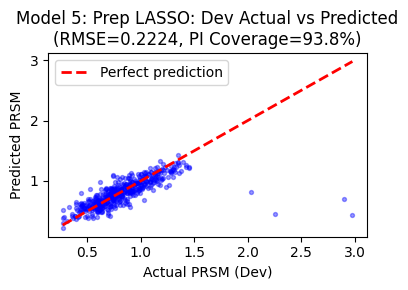

In [9]:
# Model 5: LASSO Regression (Preprocessed Predictors)

# Fit LASSO using utility function
model_preLASSO, scaler_preLASSO, metrics_preLASSO = fit_lasso_model(
    X_train_preprocessed_del, y_train_preprocessed_del, preprocessed_predictors, 'Model 5: LASSO (Preprocessed)'
)

# Store metrics
preLASSO_r2 = metrics_preLASSO['r2']
preLASSO_adj_r2 = metrics_preLASSO['adj_r2']
lasso_coefs_preLASSO = metrics_preLASSO['coefficients']

# Prepare data for residual diagnostics
X_train_preLASSO_scaled = scaler_preLASSO.transform(X_train_preprocessed_del)
y_pred_train_preLASSO = model_preLASSO.predict(X_train_preLASSO_scaled)

# Model 5: Residual diagnostics
residuals_preLASSO = y_train_preprocessed_del - y_pred_train_preLASSO
fitted_preLASSO = y_pred_train_preLASSO
plot_residuals_diagnostics(residuals_preLASSO, fitted_preLASSO, 'Model 5 (Pre LASSO)', color='lightblue')

# Model 5: Dev set validation
X_dev_preLASSO_scaled = scaler_preLASSO.transform(X_dev_preprocessed)
rmse_preLASSO, mae_preLASSO, coverage_preLASSO = validate_on_dev_set(
    model_preLASSO, X_dev_preLASSO_scaled, y_dev, 'Model 5: Prep LASSO', 'blue',
    model_type='LASSO', train_residuals=metrics_preLASSO['train_residuals']
)


## Model Comparison & Selection

In [10]:
# Comprehensive comparison table
comparison = pd.DataFrame({
    'Model': [
        'Base OLS (trim)',
        'Base LASSO',
        'Base Stepwise',
        'Prep OLS (trim)',
        'Prep Stepwise',
        'Prep LASSO'
    ],
    'Train R2': [baselineOLS_del_r2, baselineLASSO_r2, baselineStep_r2, preOLS_del_r2, preStep_r2, preLASSO_r2],
    'Adj R2': [baselineOLS_del_adj_r2, baselineLASSO_adj_r2, baselineStep_adj_r2, preOLS_del_adj_r2, preStep_adj_r2, preLASSO_adj_r2],
    'Dev RMSE': [rmse_baselineOLS_del, rmse_baselineLASSO, rmse_baselineStep, rmse_preOLS_del, rmse_preStep, rmse_preLASSO],
    'Dev MAE': [mae_baselineOLS_del, mae_baselineLASSO, mae_baselineStep, mae_preOLS_del, mae_preStep, mae_preLASSO],
    'PI Coverage (%)': [
        coverage_baselineOLS_del * 100,
        coverage_baselineLASSO * 100,
        coverage_baselineStep * 100,
        coverage_preOLS_del * 100,
        coverage_preStep * 100,
        coverage_preLASSO * 100
    ],
})

print('\n' + '=' * 120)
print('MODEL COMPARISON SUMMARY')
print('=' * 120)
display(comparison.round(4))
print('=' * 120)

# Best model by RMSE (primary)
best_rmse_idx = comparison['Dev RMSE'].idxmin()
print('\nPRIMARY CRITERION: RMSE')
print(f"Best Model: {comparison.loc[best_rmse_idx, 'Model']}")
print(f"PI Coverage: {comparison.loc[best_rmse_idx, 'PI Coverage (%)']:.2f}%")
print(f"Dev RMSE: {comparison.loc[best_rmse_idx, 'Dev RMSE']:.4f}")

# Also show top 3 by PI coverage
top_3_coverage = comparison.nlargest(3, 'PI Coverage (%)')
print('\nTop 3 Models by PI Coverage:')
for idx, row in top_3_coverage.iterrows():
    print(f"{idx+1}. {row['Model']:18s} | Coverage: {row['PI Coverage (%)']:.2f}% | RMSE: {row['Dev RMSE']:.4f}")



MODEL COMPARISON SUMMARY


,Model,Train R2,Adj R2,Dev RMSE,Dev MAE,PI Coverage (%)
0,Base OLS (trim),0.8267,0.8254,0.2168,0.1029,94.6903
1,Base LASSO,0.8263,0.8252,0.2166,0.1029,95.1327
2,Base Stepwise,0.8267,0.8254,0.2168,0.1029,94.6903
3,Prep OLS (trim),0.7843,0.7829,0.2224,0.1115,93.8053
4,Prep Stepwise,0.7843,0.7829,0.2224,0.1115,93.8053
5,Prep LASSO,0.7843,0.7829,0.2224,0.1116,93.8053



PRIMARY CRITERION: RMSE
Best Model: Base LASSO
PI Coverage: 95.13%
Dev RMSE: 0.2166

Top 3 Models by PI Coverage:
2. Base LASSO         | Coverage: 95.13% | RMSE: 0.2166
1. Base OLS (trim)    | Coverage: 94.69% | RMSE: 0.2168
3. Base Stepwise      | Coverage: 94.69% | RMSE: 0.2168


## Predcition

In [ ]:
# Final model prediction on evaluation data (point + 95% PI)
final_model_name = comparison.loc[best_rmse_idx, 'Model']
print(f"Final model: {final_model_name}")

model_registry = {
    'Base OLS (trim)': {'type': 'OLS', 'model': model_baselineOLS_del, 'predictors': base_predictors, 'train_resid': model_baselineOLS_del.resid},
    'Base LASSO': {'type': 'LASSO', 'model': model_baselineLASSO, 'scaler': scaler_baselineLASSO, 'predictors': base_predictors, 'train_resid': metrics_baselineLASSO['train_residuals']},
    'Base Stepwise': {'type': 'OLS', 'model': model_baselineStep, 'predictors': stepwise_predictors_baselineStep, 'train_resid': model_baselineStep.resid},
    'Prep OLS (trim)': {'type': 'OLS', 'model': model_preOLS_del, 'predictors': preprocessed_predictors, 'train_resid': model_preOLS_del.resid},
    'Prep Stepwise': {'type': 'OLS', 'model': model_preStep, 'predictors': stepwise_predictors_preStep, 'train_resid': model_preStep.resid},
    'Prep LASSO': {'type': 'LASSO', 'model': model_preLASSO, 'scaler': scaler_preLASSO, 'predictors': preprocessed_predictors, 'train_resid': metrics_preLASSO['train_residuals']},
}

spec = model_registry[final_model_name]
eval_df = pd.read_csv('./test_df.csv')
X_eval = eval_df[spec['predictors']].astype(float)

if spec['type'] == 'OLS':
    Xp = sm.add_constant(X_eval, has_constant='add')
    yhat = spec['model'].predict(Xp)
    pred_sf = spec['model'].get_prediction(Xp).summary_frame(alpha=0.05)
    pi_lower = pred_sf['obs_ci_lower'].to_numpy()
    pi_upper = pred_sf['obs_ci_upper'].to_numpy()
else:
    Xs = spec['scaler'].transform(X_eval)
    yhat = spec['model'].predict(Xs)
    q = np.quantile(np.abs(np.asarray(spec['train_resid'])), 0.95)
    pi_lower = yhat - q
    pi_upper = yhat + q

pred_out = pd.DataFrame({
    'point_prediction': yhat,
    'pi_lower_95': pi_lower,
    'pi_upper_95': pi_upper,
})
pred_out.to_csv('./predictions_final.csv', index=False)

print(f"Saved predictions_final.csv, rows={len(pred_out)}")
display(pred_out.head(10))



Final model: Base LASSO
Saved predictions_final.csv, rows=2500


,point_prediction,pi_lower_95,pi_upper_95
0,0.511762,0.305222,0.718301
1,0.814275,0.607735,1.020814
2,0.412299,0.205759,0.618838
3,0.728710,0.522171,0.935249
4,0.955614,0.749075,1.162154
5,1.005852,0.799312,1.212391
6,0.942038,0.735499,1.148577
7,1.157265,0.950725,1.363804
8,0.964086,0.757547,1.170625
9,0.591106,0.384567,0.797645


## Interpretation

In [12]:
# Executive summary prep: baseline borrower + main drivers
practical_effect_threshold = 0.03

model_registry = {
    'Base OLS (trim)': {'type': 'OLS', 'model': model_baselineOLS_del, 'predictors': base_predictors, 'train_X': X_train_base_del, 'train_y': y_train_base_del},
    'Base LASSO': {'type': 'LASSO', 'model': model_baselineLASSO, 'scaler': scaler_baselineLASSO, 'predictors': base_predictors, 'train_X': X_train_base_del, 'train_y': y_train_base_del},
    'Base Stepwise': {'type': 'OLS', 'model': model_baselineStep, 'predictors': stepwise_predictors_baselineStep, 'train_X': X_train_base_del[stepwise_predictors_baselineStep], 'train_y': y_train_base_del},
    'Prep OLS (trim)': {'type': 'OLS', 'model': model_preOLS_del, 'predictors': preprocessed_predictors, 'train_X': X_train_preprocessed_del, 'train_y': y_train_preprocessed_del},
    'Prep Stepwise': {'type': 'OLS', 'model': model_preStep, 'predictors': stepwise_predictors_preStep, 'train_X': X_train_preprocessed_del[stepwise_predictors_preStep], 'train_y': y_train_preprocessed_del},
    'Prep LASSO': {'type': 'LASSO', 'model': model_preLASSO, 'scaler': scaler_preLASSO, 'predictors': preprocessed_predictors, 'train_X': X_train_preprocessed_del, 'train_y': y_train_preprocessed_del},
}

spec = model_registry[final_model_name]
X_used = spec['train_X'].copy()
y_used = spec['train_y'].copy()

# baseline must include all predictors required by the final model
baseline = {}
for col in spec['predictors']:
    s = X_used[col].dropna()
    uniq = set(np.unique(s))
    if uniq.issubset({0, 1}):
        baseline[col] = int(s.mode().iloc[0])
    else:
        med = float(s.median())
        baseline[col] = round(med, 0) if abs(med) >= 100 else (round(med, 1) if abs(med) >= 10 else round(med, 2))

baseline_df_full = pd.DataFrame([baseline])[spec['predictors']]

# coefficient/p-value table for interpretation
if spec['type'] == 'OLS':
    coef_series = spec['model'].params.drop('const', errors='ignore')
    pval_series = spec['model'].pvalues.drop('const', errors='ignore')
    coef_table = pd.DataFrame({'predictor': coef_series.index, 'coef': coef_series.values, 'p_value': pval_series.reindex(coef_series.index).values})
    baseline_pred = float(spec['model'].predict(sm.add_constant(baseline_df_full, has_constant='add')).iloc[0])
else:
    orig_coef = spec['model'].coef_ / spec['scaler'].scale_
    coef_table = pd.DataFrame({'predictor': spec['predictors'], 'coef': orig_coef})
    coef_table = coef_table[coef_table['coef'] != 0].copy()

    aux_X = sm.add_constant(X_used[coef_table['predictor']], has_constant='add')
    aux_ols = sm.OLS(y_used, aux_X).fit()
    coef_table = coef_table.merge(aux_ols.pvalues.drop('const', errors='ignore').rename('p_value').reset_index().rename(columns={'index':'predictor'}), on='predictor', how='left')

    baseline_pred = float(spec['model'].predict(spec['scaler'].transform(baseline_df_full))[0])

coef_table['statistically_discernible_5pct'] = coef_table['p_value'] < 0.05

rows = []
for _, r in coef_table.iterrows():
    col = r['predictor']
    coef = float(r['coef'])
    s = X_used[col].dropna()
    uniq = set(np.unique(s))

    if uniq.issubset({0, 1}):
        delta = 1.0 if baseline[col] == 0 else -1.0
        delta_note = '0 -> 1' if baseline[col] == 0 else '1 -> 0'
    else:
        iqr = float(s.quantile(0.75) - s.quantile(0.25))
        std = float(s.std()) if float(s.std()) > 0 else 0.0
        raw_delta = iqr if iqr > 0 else (0.5 * std if std > 0 else 1.0)
        delta = round(raw_delta, 0) if abs(raw_delta) >= 100 else (round(raw_delta, 1) if abs(raw_delta) >= 10 else round(raw_delta, 2))
        if delta == 0:
            delta = 1.0
        delta_note = f'+{delta}'

    prsm_change = coef * delta
    rows.append({
        'predictor': col,
        'coef': coef,
        'p_value': r['p_value'],
        'statistically_discernible_5pct': bool(r['statistically_discernible_5pct']),
        'delta_note': delta_note,
        'implied_PRSM_change': prsm_change,
        'practically_relevant': abs(prsm_change) >= practical_effect_threshold,
        'risk_direction_vs_baseline': 'greater risk (higher PRSM)' if prsm_change > 0 else 'lesser risk (lower PRSM)',
    })

driver_table = pd.DataFrame(rows).sort_values('implied_PRSM_change', key=lambda x: np.abs(x), ascending=False)
main_drivers = driver_table[driver_table['practically_relevant']].copy()
stat_not_practical = driver_table[(driver_table['statistically_discernible_5pct']) & (~driver_table['practically_relevant'])].copy()

print(f"Baseline predicted PRSM: {baseline_pred:.4f}")
print(f"Practical threshold |Delta PRSM| >= {practical_effect_threshold}")

print("\nBaseline borrower profile:")
display(pd.DataFrame({'predictor': baseline_df_full.columns, 'baseline_value': baseline_df_full.iloc[0].values}))

print("\nMain drivers:")
display(main_drivers[['predictor', 'delta_note', 'implied_PRSM_change', 'risk_direction_vs_baseline', 'p_value', 'statistically_discernible_5pct']])

print("\nStatistically discernible but not practically relevant:")
display(stat_not_practical[['predictor', 'delta_note', 'implied_PRSM_change', 'p_value']])

pd.DataFrame({'baseline_predicted_prsm': [baseline_pred]})
pd.DataFrame({'predictor': baseline_df_full.columns, 'baseline_value': baseline_df_full.iloc[0].values})



Baseline predicted PRSM: 0.5479
Practical threshold |Delta PRSM| >= 0.03

Baseline borrower profile:


,predictor,baseline_value
0,FICO_category,2.00
1,TotalAmtOwed,194674.00
2,Volume,84626.00
3,Stress,0.19
4,Num_Delinquent,4.00
5,Num_CreditLines,10.00
6,Prop_Delinquent_Credit,0.40
7,WomanOwned,0.00
8,Months,18.00
9,CorpStructure_Corp,0.00



Main drivers:


,predictor,delta_note,implied_PRSM_change,risk_direction_vs_baseline,p_value,statistically_discernible_5pct
5,WomanOwned,0 -> 1,0.278451,greater risk (higher PRSM),0.000000e+00,True
8,CorpStructure_LLC,0 -> 1,0.241039,greater risk (higher PRSM),3.528439e-207,True
9,CorpStructure_Partner,0 -> 1,0.170082,greater risk (higher PRSM),1.570047e-116,True
0,FICO_category,+2.0,0.109998,greater risk (higher PRSM),4.868704e-58,True
1,TotalAmtOwed,+200985.0,0.099704,greater risk (higher PRSM),2.668438e-227,True
3,Stress,+0.15,0.070250,greater risk (higher PRSM),4.403340e-74,True



Statistically discernible but not practically relevant:


,predictor,delta_note,implied_PRSM_change,p_value
7,CorpStructure_Corp,0 -> 1,0.026665,3.924804e-06
6,Months,+6.0,0.012979,7.374578e-08


,predictor,baseline_value
0,FICO_category,2.00
1,TotalAmtOwed,194674.00
2,Volume,84626.00
3,Stress,0.19
4,Num_Delinquent,4.00
5,Num_CreditLines,10.00
6,Prop_Delinquent_Credit,0.40
7,WomanOwned,0.00
8,Months,18.00
9,CorpStructure_Corp,0.00
